In [1]:
from matplotlib import pyplot
import numpy
import pandas
from scipy import stats
import seaborn

import sensitivity_analysis

# A trivial model

$$R_0(\beta, \gamma, \mu) = \frac{\beta}{\gamma + \mu},$$
where
$$\begin{aligned}
\beta &\sim \Gamma(0.03, 4), \\
\gamma &\sim \Gamma(0.01, 4), \\
\mu &\sim \Gamma(0.00001, 4),
\end{aligned}$$
where $\Gamma(a, k)$ is the standard gamma random variable with mean $a$ and shape $k$.

In [2]:
def model(𝛽, 𝛾, 𝜇):
    '''Compute R_0 from the transmission rate, recovery rate, and death rate.'''
    R_0 = 𝛽 / (𝛾 + 𝜇)
    return R_0


# Let the transmission rate be a Gamma random variable.
beta_mean = 0.03
beta_shape = 4
beta_scale = beta_mean / beta_shape
beta = stats.gamma(beta_shape, scale=beta_scale)

# Let the recovery rate be a Gamma random variable.
gamma_mean = 0.01
gamma_shape = 4
gamma_scale = gamma_mean / gamma_shape
gamma = stats.gamma(gamma_shape, scale=gamma_scale)

# Let the death rate be a Gamma random variable.
mu_mean = 0.00001
mu_shape = 4
mu_scale = mu_mean / mu_shape
mu = stats.gamma(mu_shape, scale=mu_scale)

parameters = dict(𝛽=beta,
                  𝛾=gamma,
                  𝜇=mu)

# Uncertainty analysis

With each sampling method, get the mean value of $R_0$ over 100 samples of each parameter. Repeat this process 1000 times and look at the distribution of mean $R_0$ values.

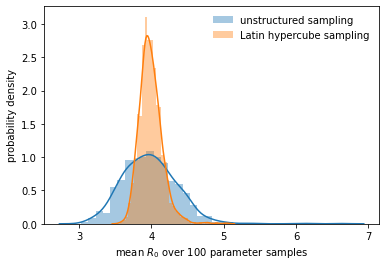

In [3]:
n_runs = 1000
n_samples = 100


def get_mean_output(sampler, model, parameters, n_samples, n_runs):
    '''For each run in `n_runs`,
    find the mean output of `model()` 
    over `n_samples` samples from `parameters` using
    `sampler()`.'''
    means = []
    for _ in range(n_runs):
        parameter_samples = sampler(parameters, n_samples)
        model_outputs = model(**parameter_samples)
        means.append(numpy.mean(model_outputs))
    return means


means = get_mean_output(sensitivity_analysis.sampling.get_unstructured,
                        model, parameters,
                        n_samples, n_runs)

means_LHS = get_mean_output(sensitivity_analysis.sampling.get_Latin_hypercube,
                            model, parameters,
                            n_samples, n_runs)

seaborn.distplot(means, label='unstructured sampling')
seaborn.distplot(means_LHS, label='Latin hypercube sampling')
pyplot.xlabel(f'mean $R_0$ over {n_samples} parameter samples')
pyplot.ylabel('probability density')
_ = pyplot.legend()

Both sampling schemes give the same mean $R_0$ of around 4, but the variation in the estimates is much smaller with Latin hypercube sampling.

# PRCC

In [4]:
n_samples = 100
X = sensitivity_analysis.sampling.get_Latin_hypercube(parameters, n_samples)
y = model(**X)
y.name = r'final size'

## Correlation coefficient

In [5]:
sensitivity_analysis.stats.cc(X, y)

β    0.488483
γ   -0.531023
μ    0.095969
dtype: float64

In [6]:
def get_regression_line(x, y):
    '''Get the regression line of y against x.'''
    coef = numpy.polyfit(x, y, deg=1)
    x_ends = (x.min(), x.max())
    y_ends = numpy.polyval(coef, x_ends)
    return (x_ends, y_ends)

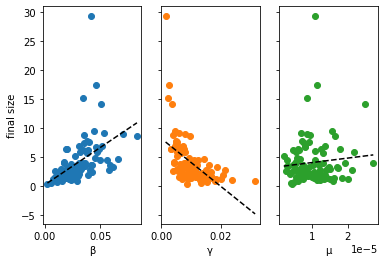

In [7]:
(fig, axes) = pyplot.subplots(1, X.shape[-1], sharey='row')
for (i, (label, x)) in enumerate(X.items()):
    axes[i].scatter(x, y, color=f'C{i}')
    axes[i].plot(*get_regression_line(x, y),
                 color='black', linestyle='dashed')
    axes[i].set_xlabel(x.name)
_ = axes[0].set_ylabel(y.name)

## Partial correlation coefficient

In [8]:
sensitivity_analysis.stats.pcc(X, y)

β    0.608059
γ   -0.639528
μ    0.085061
dtype: float64

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


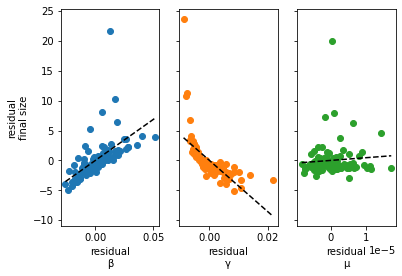

In [9]:
(fig, axes) = pyplot.subplots(1, X.shape[-1], sharey='row')
for (i, (label, x)) in enumerate(X.items()):
    Z = X.drop(columns=label) # All the parameters except X_i.
    x_res = sensitivity_analysis.stats.get_linear_residuals(Z, x)
    y_res = sensitivity_analysis.stats.get_linear_residuals(Z, y)
    axes[i].scatter(x_res, y_res, color=f'C{i}')
    axes[i].plot(*get_regression_line(x_res, y_res),
                 color='black', linestyle='dashed')
    axes[i].set_xlabel(f'residual\n{x.name}')
_ = axes[0].set_ylabel(f'residual\n{y.name}')

## Rank correlation coefficient

In [10]:
sensitivity_analysis.stats.rcc(X, y)

β    0.716688
γ   -0.655806
μ   -0.017438
dtype: float64

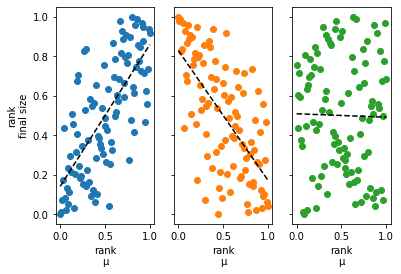

In [11]:
X_rank = sensitivity_analysis.stats.get_rank(X)
y_rank = sensitivity_analysis.stats.get_rank(y)
(fig, axes) = pyplot.subplots(1, X_rank.shape[-1], sharey='row')
for (i, (label, x_rank)) in enumerate(X_rank.items()):
    axes[i].scatter(x_rank, y_rank, color=f'C{i}')
    axes[i].plot(*get_regression_line(x_rank, y_rank),
                 color='black', linestyle='dashed')
    axes[i].set_xlabel(f'rank\n{x.name}')
_ = axes[0].set_ylabel(f'rank\n{y.name}')

## Partial rank correlation coefficient

In [12]:
sensitivity_analysis.stats.prcc(X, y)

β    0.958011
γ   -0.950657
μ   -0.173120
dtype: float64

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


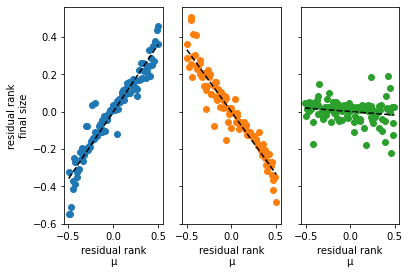

In [13]:
(fig, axes) = pyplot.subplots(1, X_rank.shape[-1], sharey='row')
for (i, (label, x_rank)) in enumerate(X_rank.items()):
    Z = X_rank.drop(columns=label) # All the parameters except X_i.
    x_res = sensitivity_analysis.stats.get_linear_residuals(Z, x_rank)
    y_res = sensitivity_analysis.stats.get_linear_residuals(Z, y_rank)
    axes[i].scatter(x_res, y_res, color=f'C{i}')
    axes[i].plot(*get_regression_line(x_res, y_res),
                 color='black', linestyle='dashed')
    axes[i].set_xlabel(f'residual rank\n{x.name}')
_ = axes[0].set_ylabel(f'residual rank\n{y.name}')

# Sobol' indexes

The first-order index is
$$S_i = \frac{\mathrm{V}_{X_i}\big(\mathrm{E}_{X_{\sim i}}(Y|X_i)\big)}{\mathrm{V}(Y)},$$
and the total-order index is
$$S_{\mathrm{T}i} = \frac{\mathrm{E}_{X_{\sim i}}\big(\mathrm{V}_{X_i}(Y|X_{\sim i})\big)}{\mathrm{V}(Y)}.$$


In [15]:
def bold_sum(s):
    '''Made the 'Sum' row bold.'''
    is_sum = (s.index == 'Sum')
    return ['font-weight: bold' if v else '' for v in is_sum]


def display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=0.5):
    '''Display the Sobol' indexes S and S_T in a nice table.'''
    table = pandas.concat((S, S_PE, S_T, S_T_PE), axis='columns')
    CI_percent = 100 * (1 - alpha)
    columns = pandas.MultiIndex.from_product(
        (('First-order index ($S$)', 'Total-order index ($S_T$)'),
         ('Estimate', f'{CI_percent:g}% probable error')))
    table.set_axis(columns, axis='columns', inplace=True)
    table.loc['Sum'] = table.sum()
    # Don't show the sum of the probable errors.
    estimates = (columns.get_level_values(1) == 'Estimate')
    table.loc['Sum', ~estimates] = ''
    display(table.style.apply(bold_sum))


n_samples = 1000
(S, S_PE, S_T, S_T_PE) = sensitivity_analysis.sobol_index.get_indexes(
    model, parameters, n_samples)
display_Sobol_indexes(S, S_PE, S_T, S_T_PE)